### Logistic regression analysis
#### London Bike share dataset for 2015 & 2016 from Kaggle (https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset). For the Logstic regression analysis I've only used 2016 data. In the first half of analysis I tried to understand the probability score of Season based on total number of bikes shared, Humidity, and Wind_speed. In the later part of analysis I focused on understanding the probability of Is_Weekend or not based on total number of bikes shared (cnt). 

In [107]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
# Keep only columns needed for the analysis and drop the rest from the dataframe.  
ldn_bike = pd.read_csv("london_merged.csv")
ldn_bike['is_weekend'] = ldn_bike['is_weekend'].apply(np.int64)
ldn_bike['season'] = ldn_bike['season'].apply(np.int64)
ldn_bike.dropna
ldn_bike.drop(['t1', 't2', 'weather_code','is_holiday','is_weekend'], axis=1, inplace=True)
ldn_bike.head()


,timestamp,cnt,hum,wind_speed,season
0,2015-01-04 00:00:00,182,93.0,6.0,3
1,2015-01-04 01:00:00,138,93.0,5.0,3
2,2015-01-04 02:00:00,134,96.5,0.0,3
3,2015-01-04 03:00:00,72,100.0,0.0,3
4,2015-01-04 04:00:00,47,93.0,6.5,3


In [109]:
ldn_bike['timestamp'] = pd.to_datetime(ldn_bike['timestamp'], format="%Y-%m-%d %H:%M:%S")
ldn_bike['year']  = ldn_bike['timestamp'].dt.year

In [110]:
ldn_bike.dtypes

timestamp     datetime64[ns]
cnt                    int64
hum                  float64
wind_speed           float64
season                 int64
year                   int64
dtype: object

In [111]:
# Records for year 2016 and exclude data for Winter (season = 3)
ldn_bike2016 = ldn_bike[(ldn_bike.year == 2016) & (ldn_bike.season != 3)]
print(ldn_bike2016.shape)
ldn_bike2016.head()

(6523, 6)


,timestamp,cnt,hum,wind_speed,season,year
10075,2016-03-01 00:00:00,29,73.5,19.5,0,2016
10076,2016-03-01 01:00:00,14,81.0,17.0,0,2016
10077,2016-03-01 02:00:00,16,81.0,18.0,0,2016
10078,2016-03-01 03:00:00,14,84.0,17.0,0,2016
10079,2016-03-01 04:00:00,32,87.0,17.0,0,2016


In [112]:
bike_final = ldn_bike2016[['cnt','hum','wind_speed','season']].copy()
print(bike_final.shape)
bike_final.head()

(6523, 4)


,cnt,hum,wind_speed,season
10075,29,73.5,19.5,0
10076,14,81.0,17.0,0
10077,16,81.0,18.0,0
10078,14,84.0,17.0,0
10079,32,87.0,17.0,0


In [113]:
# Predictor variables "cnt", "hum", "wind_speed" and Target variable "season"
X = bike_final[["cnt","hum","wind_speed"]]
y = bike_final.season
X.shape, y.shape

((6523, 3), (6523,))

In [114]:
# Copy all except the last records into X, and y data frames
X = bike_final.iloc[:-1,:3]  
y = bike_final.iloc[:-1,3]
print(X.shape, y.shape)

(6522, 3) (6522,)


In [115]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [116]:
# Fit logistric regression model on the X, and y dataframes
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
# Get score for prediciting the last row
logistic.score( bike_final.iloc[-1,:3].values.reshape(1,-1), bike_final.iloc[-1,3].reshape(-1,1) )

0.0

In [118]:
# Show predicted vs actual class for last row
print( 'Predicted class %s, real class %s' % (logistic.predict(bike_final.iloc[-1,:3].values.reshape(1,-1)),bike_final.iloc[-1,3]) )

# Show probabilities for each class - for the last row again
print( 'Probabilities for each class from 0 to 2: %s' % logistic.predict_proba(bike_final.iloc[-1,:3].values.reshape(1,-1) ) )

Predicted class [0], real class 2
Probabilities for each class from 0 to 2: [[0.42817342 0.33529914 0.23652744]]


#### Probability of each season 0-spring ; 1-summer; 2-fall for the given input. 

In [119]:
X = bike_final[["cnt","hum","wind_speed"]]
y = bike_final.season
X.shape, y.shape

((6523, 3), (6523,))

In [120]:
# Split the data into Test and Training sets, with a test size of 40%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.40, random_state=9)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3913, 3) (3913,)
(2610, 3) (2610,)


In [121]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
OVR = OneVsRestClassifier(logistic).fit(X_train,y_train)
OVO = OneVsOneClassifier(logistic).fit(X_train,y_train)
print( 'One vs rest accuracy: %.3f' % OVR.score(X_test,y_test) )
print( 'One vs one accuracy: %.3f' % OVO.score(X_test,y_test) )

One vs rest accuracy: 0.431
One vs one accuracy: 0.427


In [122]:
LR = LogisticRegression()
LR.fit(X_train,y_train)
print( 'One vs rest accuracy: %.3f' % LR.score(X_test,y_test) )

One vs rest accuracy: 0.431


#### Model is predicting the accurate result 43% of cases

In [123]:
# Calculate model accuracy score
from sklearn import metrics
y_pred = LR.predict(X_test)
print('log: %.3f' % metrics.accuracy_score(y_test, y_pred))

log: 0.431


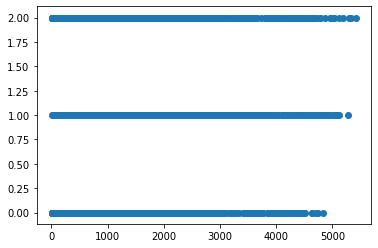

In [124]:
plt.scatter(X_train.iloc[:,0],y_train)

<function matplotlib.pyplot.show(*args, **kw)>

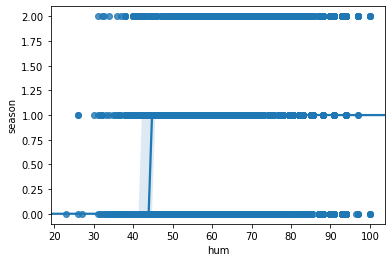

In [126]:
np.seterr(divide='ignore', invalid='ignore')
plt.figure()
sns.regplot(X_train.iloc[:,1],y_train, logistic=True)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

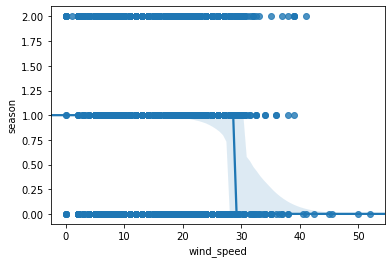

In [127]:
np.seterr(divide='ignore', invalid='ignore')
sns.regplot(X_train.iloc[:,2],y_train, logistic=True)
plt.show

#### Logistric regression analysis with one predictor variable follows

In [128]:
ldnbike_share = pd.read_csv("london_merged.csv")
ldnbike_share['is_weekend'] = ldnbike_share['is_weekend'].apply(np.int64)
ldnbike_share['season'] = ldnbike_share['season'].apply(np.int64)
ldnbike_share.dropna
ldnbike_share.drop(['t1', 't2', 'hum', 'wind_speed', 'weather_code'], axis=1, inplace=True)
ldnbike_share.head()

,timestamp,cnt,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,0.0,1,3
1,2015-01-04 01:00:00,138,0.0,1,3
2,2015-01-04 02:00:00,134,0.0,1,3
3,2015-01-04 03:00:00,72,0.0,1,3
4,2015-01-04 04:00:00,47,0.0,1,3


In [129]:
ldnbike_share['timestamp'] = pd.to_datetime(ldn_bike['timestamp'], format="%Y-%m-%d %H:%M:%S")
ldnbike_share['year']  = ldnbike_share['timestamp'].dt.year

In [130]:
ldnbike_share.dtypes

timestamp     datetime64[ns]
cnt                    int64
is_holiday           float64
is_weekend             int64
season                 int64
year                   int64
dtype: object

In [131]:
ldnbike_share.head()

,timestamp,cnt,is_holiday,is_weekend,season,year
0,2015-01-04 00:00:00,182,0.0,1,3,2015
1,2015-01-04 01:00:00,138,0.0,1,3,2015
2,2015-01-04 02:00:00,134,0.0,1,3,2015
3,2015-01-04 03:00:00,72,0.0,1,3,2015
4,2015-01-04 04:00:00,47,0.0,1,3,2015


In [132]:
bike_share2016 = ldnbike_share[(ldnbike_share.year == 2016) & (ldnbike_share.season == 1)]

In [133]:
bike_share2016.shape

(2186, 6)

In [134]:
bike_share2016.head()

,timestamp,cnt,is_holiday,is_weekend,season,year
12267,2016-06-01 00:00:00,174,0.0,0,1,2016
12268,2016-06-01 01:00:00,115,0.0,0,1,2016
12269,2016-06-01 02:00:00,71,0.0,0,1,2016
12270,2016-06-01 03:00:00,76,0.0,0,1,2016
12271,2016-06-01 04:00:00,84,0.0,0,1,2016


In [135]:
# Predictor variable "cnt", and Target variable "is_weekend"
A = bike_share2016.cnt.values.reshape(-1,1)
b = bike_share2016.is_weekend

In [140]:
A.shape, b.shape

((2186, 1), (2186,))

In [141]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [142]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(A,b)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [143]:
logistic.score(A[-1,:].reshape(-1,1), b[-1:])

1.0

#### The score here with one predictor is 1 vs 0 for multiple predictors, for predicting the last row

In [144]:
print( 'Probabilities for each class from 0 to 2: %s' % logistic.predict_proba(A[-1,:].reshape(-1,1)))

Probabilities for each class from 0 to 2: [[0.69828577 0.30171423]]


In [145]:
from sklearn.model_selection import train_test_split
A_train, A_test, b_train, b_test = train_test_split( A, b, test_size=0.30, random_state=9)
print(A_train.shape, b_train.shape)
print(A_test.shape, b_test.shape)

(1530, 1) (1530,)
(656, 1) (656,)


In [146]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
OVR = OneVsRestClassifier(logistic).fit(A_train,b_train)
OVO = OneVsOneClassifier(logistic).fit(A_train,b_train)
print( 'One vs rest accuracy: %.3f' % OVR.score(A_test,b_test) )
print( 'One vs one accuracy: %.3f' % OVO.score(A_test,b_test) )

One vs rest accuracy: 0.713
One vs one accuracy: 0.713


#### Even with different test sizes from 10% to 50%, got the same OVR and OVO score always

In [147]:
LR = LogisticRegression()
LR.fit(A_train,b_train)
print( 'One vs rest accuracy: %.3f' % LR.score(A_test,b_test) )

One vs rest accuracy: 0.713


#### For the given the number of bikes shared on any day, the chance of that day not being a weekend is 71.3%

In [148]:
# Calculate model accuracy score
from sklearn import metrics
b_pred = LR.predict(A_test)
print('log: %.3f' % metrics.accuracy_score(b_test, b_pred))

log: 0.713


#### The model is accurate in approx 71% of cases 

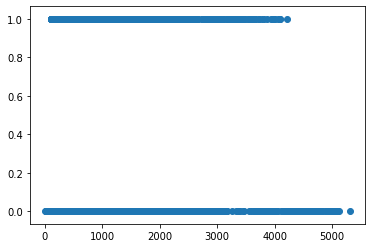

In [149]:
plt.scatter(A_train,b_train)

<function matplotlib.pyplot.show(*args, **kw)>

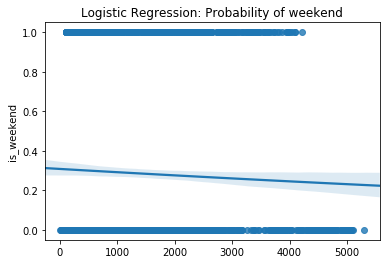

In [150]:
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
plt.figure()
sns.regplot(A_train,b_train, logistic=True)
plt.title('Logistic Regression: Probability of weekend')
plt.show

#### Analysis: Unlime when there are more predictor variables, for one predictor variable case, both One vs. One and One vs. Rest have the same score, which is 71.3%. When there are move predictors, there's a slight variability in the model, 43% vs 42.7% for OVR and OVO classifications. Model has a better prediction rate when the traget variable has fewer classifications. 